# Craigslist Capstone Project - Data Wrangling

#### The goal of this capstone is to predict market rent prices in the San Francisco Bay Area. The metros of interest are San Francisco, Peninsula, East Bay. 

Prior to this notebook, the html from craigslist.com rental listings is parsed and saved as a csv file
* Listing price is the variable we want to predict
* Listing features include number of bedrooms, bathrooms, address, neighborhood, and optional features provided in `listing_info` and `listing_body` such as whether cats and dogs are allowed, if the rental unit is offered furnished. 
* Each listing has a unique Listing ID which is set as the index of the dataframe.
* The listing pages are scraped every 4 days, which means there will be duplicate listings that are exactly the same, and duplicates that are posted over time but are for the same rental unit.


#### This notebook covers the scope of cleaning, transforming and visualizing

1. Drop rows with missing price data and remove duplicate listings
2. Convert data types into appropriate ones for machine learning
3. Clean listing_bathrooms column
4. Clean listing_bedrooms column
5. Filter the listing_sqft column using a chosen min/max
6. Extract listing_info keywords
7. Filter the listing_city column based on how often it occurs
8. Check the metro, neighborhood and listing_city is consistent
9. Add Walk Score, Transit Score and Bike Score data
10. Handle missing values
11. Extract listing_title keywords
12. Convert dtypes of bedrooms and bathrooms columns
13. Extract listing_body into keywords
14. Summarize the data visually


## Importing the libraries

In [1]:
#Run the following once to install libraries needed for Matplotlib to work
#!conda install nomkl numpy scipy scikit-learn numexpr -y
#!conda remove mkl mkl-service -y

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import requests
import contextlib
import os
import sqlite3
import bs4
from bs4 import BeautifulSoup
import time
import random
import warnings # For handling error messages. 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
# Neighborhoods in SF
SFC_NEIGHBORHOODS = ['alamo square / nopa', 'bayview', 'bernal heights', 'castro / upper market', 'cole valley / ashbury hts', 'downtown / civic / van ness',
 'excelsior / outer mission', 'financial district', 'glen park', 'haight ashbury', 'hayes valley', 'ingleside / SFSU / CCSF', 'inner richmond',
 'inner sunset / UCSF', 'laurel hts / presidio', 'lower haight', 'lower nob hill', 'lower pac hts', 'marina / cow hollow', 'mission district',
 'nob hill', 'noe valley', 'north beach / telegraph hill', 'pacific heights', 'portola district', 'potrero hill', 'richmond / seacliff', 'russian hill', 
'SOMA / south beach', 'sunset / parkside', 'tenderloin','treasure island', 'twin peaks / diamond hts', 'USF / panhandle', 'visitacion valley', 
'west portal / forest hill', 'western addition']

# Neighborhoods in Peninsula
PEN_NEIGHBORHOODS = ['atherton','belmont','brisbane','burlingame','coastside/pescadero','daly city','east palo alto','foster city','half moon bay','los altos','menlo park','millbrae',
                     'mountain view','pacifica','palo alto','portola valley','redwood city','redwood shores','san bruno','san carlos','san mateo','south san francisco','woodside']

# Neighborhoods in the East Bay
EBY_NEIGHBORHOODS = ['alameda','albany / el cerrito','berkeley','berkeley north / hills','brentwood / oakley','concord / pleasant hill / martinez','danville / san ramon',
                     'dublin / pleasanton / livermore','emeryville','fairfield / vacaville','fremont / union city / newark','hayward / castro valley','hercules, pinole, san pablo, el sob',
                     'lafayette / orinda / moraga','oakland downtown','oakland east','oakland hills / mills','oakland lake merritt / grand','oakland north / temescal',
                     'oakland piedmont / montclair','oakland rockridge / claremont','oakland west','pittsburg / antioch','richmond / point / annex','san leandro','vallejo / benicia','walnut creek']
# List of cities
SFC_CITIES = ['San Francisco']
PEN_CITIES = ['Palo Alto','San Mateo','Mountain View','Redwood City','Menlo Park','Daly City','San Bruno','South San Francisco','Foster City','Burlingame']
EBY_CITIES = ['Oakland','Berkeley','Fremont','Walnut Creek','Concord','Hayward','Alameda','Pleasanton','San Leandro','Vallejo','San Ramon','Emeryville',
        'Dublin','Richmond','Fairfield','Livermore','Antioch','Pittsburg','Union City','El Cerrito']

ALL_CITIES = SFC_CITIES + PEN_CITIES + EBY_CITIES

# Dictionaries for neighborhood and city relationship
METRO_TO_NEIGHBORHOODS = {'sfc': SFC_NEIGHBORHOODS, 'pen': PEN_NEIGHBORHOODS, 'eby': EBY_NEIGHBORHOODS}
METRO_TO_CITIES = {'sfc': SFC_CITIES, 'pen': PEN_CITIES, 'eby': EBY_CITIES}

NEIGHBORHOOD_TO_METRO = {neighborhood: metro for metro, neighborhoods in METRO_TO_NEIGHBORHOODS.items() for neighborhood in neighborhoods}
CITY_TO_METRO = {city: metro for metro,cities in METRO_TO_CITIES.items() for city in cities}

# Create a dictionary mapping listing_info values to the categorical column name
LISTING_INFO_TO_COLUMN = {'cats are OK - purrr':'animals_cats','dogs are OK - wooof':'animals_dogs','furnished':'furnished',
                    'no smoking':'smoking','wheelchair accessible':'wheelchair accessible','air conditioning':'has_AC',
                     'EV charging':'hasEVCharging','laundry in bldg':'laundry_in_bldg','w/d in unit':'laundry_in_unit',
                     'w/d hookups':'laundry_has_hookup','laundry on site':'laundry_onsite','no laundry on site':'laundry_not_onsite',
                     'carport':'parking_carport','attached garage':'parking_attached_garage','detached garage':'parking_detached_garage',
                     'off-street parking':'parking_offstreet','street parking':'parking_street','valet parking':'parking_valet','no parking':'parking_none',
                     'rent period: daily':'rent_period_daily','rent period: weekly':'rent_period_weekly','rent period: monthly':'rent_period_monthly',
                     'condo':'housing_condo','apartment':'housing_apt','cottage/cabin':'housing_cottage','duplex':'housing_duplex',
                     'flat':'housing_flat','house':'housing_house','in-law':'housing_inlaw','loft':'housing_inlaw','townhouse':'housing_townhouse'}

# Create a dictionary mapping listing_body features to the categorical column name
LISTING_BODY_TO_COLUMN = {'(rent control)|(rent ordinance)':'is_rent_controlled','no pets':'pets_allowed','remodelled':'is_remodelled',
                         '(amenities)|(pool)|(gym)|(spa)':'has_amenities', 
                          '(granite)|(marble)|(walnut)|(millwork)|(fireplace)|(built-in cabinetry)':'premium_finishes',
                         'ensuite':'ensuite_bath','(balcony)|(balconies)':'has_balcony','backyard':'has_backyard',
                         '(view)|(views)|(penthouse)':'has_view', '([345])\s((stor[a-z]?)|(floor[a-z]?)|(level[a-z]?)){1}':'multi-level',
                         '(roommate[a-z]?)|(flatmate[a-z]?)|(housemate[a-z]?)|1 room available|own room|private room|shared housing|home share|room for rent|share|not the entire unit':'is_shared',
                         'sro': 'is_an_SRO'}

# Create a dictionary mapping listing_body number of bed/bathrooms
LISTING_BODY_NUM = {'([0-6])\s((bed[a-z]?)|(room[a-z]?)){1}':'text_no_bedrooms', '([0-5])\s(bath[a-z]?){1}':'text_no_bathrooms'}

In [4]:
# Check the metro and neighborhood is consistent
def correct_metro(neighborhood, city):
    if city in CITY_TO_METRO:
        return NEIGHBORHOOD_TO_METRO[neighborhood] == CITY_TO_METRO[city]
    else:
        return False
    
def clean_city(city):
    city = city.strip()
    city = city.strip('.')
    if ',' in city:
        return city.split(',')[0]
    if '/' in city:
        return city.split('/')[0]
    return city

# Extract key features from listing_info
def get_listing_info_feature(listing_info_split, target_info):
    for info in listing_info_split:
        if info == target_info:
            return 1
    return 0

# Extract key features from listing_body
def parse_listing_body(text,target_word):
    text = re.sub(r'[^\w\s]', '', text)
    for key in LISTING_BODY_TO_COLUMN.keys():
        if re.search(target_word, text.lower()) is not None:
            return 1
    return 0

# Extract number of bed/bath from listing_body
def parse_listing_number(text,target_word):
    text = re.sub(r'[^\w\s]', '', text)
    for key in LISTING_BODY_NUM.keys():
        x = re.search(target_word, text.lower())
        if x is not None:
            return x.group(1)
    return None

# Extract key features from listing_title
def parse_listing_title_sqft(text):
    pattern = '(\d+)\s?ft2'
    if re.search(pattern, text.lower()) is not None:
        return int(re.search(pattern, text.lower()).group(1))
    return

## Walkscore scraping
These functions extract the walk score, transit score and bike score from the walkscore.com website given an address

In [5]:
DATABASE = '/Users/pandabear/springboard/CapstoneTwoProject/data/interim/walkscore.db'
HTML_DIRECTORY = '/Users/pandabear/springboard/CapstoneTwoProject/data/interim'
DEBUG = False

def get_walk_score(conn, full_address):
    query = 'SELECT walk_score, transit_score, bike_score FROM walkscore WHERE full_address = ?'
    cur = conn.cursor()
    cur.execute(query, (full_address,))
    row = cur.fetchone()
    if row:
        return (row[0] or None, row[1] or None, row[2] or None,)


def insert_walk_score(conn, full_address, walk_score, transit_score, bike_score):
    query = 'INSERT INTO walkscore (full_address, walk_score, transit_score, bike_score) VALUES (?, ?, ?, ?)'
    cur = conn.cursor()
    cur.execute(query, (full_address, walk_score, transit_score, bike_score,))
    conn.commit()
    
# Add walk score if there is an address
walk_score_root_URL = 'https://www.walkscore.com/score/'
# walk score website url address example format '562-29th-st-oakland'

def get_address_score(conn, address, city):
    full_address = str(address) + " " + str(city)
    full_address = full_address.replace('"','')
    
    # Check address is not np.nan
    if address == np.nan:
        walk_score = None
        transit_score = None
        bike_score = None
        return insert_walk_score(conn, full_address, walk_score, transit_score, bike_score)
    
    # If address is valid, check it is in the walkscore database
    if get_walk_score(conn, full_address):
        return get_walk_score(conn, full_address)
    
    else:
        # Else, scrape the scores from the walkscore website
        address_url = "-".join(str(address).split())
        city_url = "-".join(str(city).split())
        walk_score_url = walk_score_root_URL + address_url + "-" + city_url

    #     print(f'URL of walk score to scrape: {walk_score_url}')
        r = requests.get(walk_score_url)
    #     r.raise_for_status()
        if r.status_code != 200:
            print('Request: {}; Status code: {}'.format(r, r.status_code))
            walk_score = None
            transit_score = None
            bike_score = None
            insert_walk_score(conn, full_address, walk_score, transit_score, bike_score)
            return 

        soup = bs4.BeautifulSoup(r.text, 'html.parser')

        # Get walk score
        div_walk = soup.find("div", {"class": "block-header-badge score-info-link", "data-eventsrc": "score page walk badge"})
        if div_walk == None:
            walk_score = None
        else:
            img_walk = div_walk.findChild('img')
            walk_text_before_regex = img_walk.get('src')
            walk_score = int(re.search('/(\d+)\.svg$', walk_text_before_regex)[1])

        # Get transit score
        div_transit = soup.find("div", {"class": "block-header-badge score-info-link", "data-eventsrc": "score page transit badge"})
        if div_transit == None:
            transit_score = None
        else:
            img_transit = div_transit.findChild('img')
            transit_text_before_regex = img_transit.get('src')
            transit_score = int(re.search('/(\d+)\.svg$', transit_text_before_regex)[1])

        # Get biking score
        div_bike = soup.find("div", {"class": "block-header-badge score-info-link", "data-eventsrc": "score page bike badge"})
        if div_bike == None:
            bike_score = None
        else:
            img_bike = div_bike.findChild('img')
            bike_text_before_regex = img_bike.get('src')
            bike_score = int(re.search('/(\d+)\.svg$', bike_text_before_regex)[1])

    # Add new scores to walkscore database
    insert_walk_score(conn, full_address, walk_score, transit_score, bike_score)
    
    # Add a delay between requests
    time.sleep(random.uniform(1.5, 2.5))

    return walk_score[:1] if DEBUG else [walk_score,transit_score,bike_score]

## Load the data

In [6]:
# The parsed html listing data is the interim directory
dir_folder = '/Users/pandabear/springboard/CapstoneTwoProject/data/interim/'
listing_df = pd.read_csv(dir_folder + 'listing_df_parsed.csv',index_col='listing_id')

In [7]:
listing_df.head()

,listing_title,listing_nh,listing_city,listing_date,listing_price,listing_bedrooms,listing_bathrooms,listing_sqft,listing_address,listing_info,listing_body,listing_url,listing_first_image
listing_id,,,,,,,,,,,,,
7506354686,"At Last, This Is What You’ve Been Searching For",fremont / union city / newark,Union City,2022-07-08T11:18:15-0700,3250,2,2,1226.0,24 Union Square,air conditioning cats are OK - purrr dogs a...,Furnished Available -Parking -Pool -Controlle...,https://sfbay.craigslist.org/eby/apa/d/union-c...,https://images.craigslist.org/00P0P_hZ2AtgxDfz...
7508776873,"Upgraded Single Family Home in San Pablo, CA","hercules, pinole, san pablo, el sob",San Pablo,2022-07-14T11:52:10-0700,2600,2,1,NaN,1625 15th Street,application fee details: $45 Online Applicati...,"Upgraded Single Family Home in San Pablo, CA...",https://sfbay.craigslist.org/eby/apa/d/richmon...,https://images.craigslist.org/00101_70g2UwYKVU...
7520158858,"Business Center, Parcel Lockers, Disposal, Com...",fairfield / vacaville,Fairfield,2022-08-11T11:38:28-0700,2102,1,1,712.0,3900 Business Center Dr near Business Center D...,cats are OK - purrr dogs are OK - wooof apa...,Verdant at Green Valley 3900 Business Center D...,https://sfbay.craigslist.org/eby/apa/d/fairfie...,https://images.craigslist.org/00707_7hc2WHQqbx...
7509730537,Unwind at Casa Serena!,fremont / union city / newark,Fremont,2022-07-16T16:43:33-0700,2325,1,1,610.0,36000 Fremont Blvd,cats are OK - purrr dogs are OK - wooof apa...,To schedule a tour We now book our tour appoin...,https://sfbay.craigslist.org/eby/apa/d/fremont...,https://images.craigslist.org/00N0N_5CCDB2ckEM...
7516143553,House for rent - 5 mins walk to Bart 3bed room...,san leandro,San Leandro,2022-08-01T14:25:13-0700,3500,3,2,1300.0,NaN,air conditioning cats are OK - purrr dogs a...,3 Beds 2 Baths single family house Excellent ...,https://sfbay.craigslist.org/eby/apa/d/san-lea...,https://images.craigslist.org/00z0z_cJsvz9nR7M...


In [8]:
listing_df.describe()

,listing_price,listing_bedrooms,listing_sqft
count,2.507463e+06,2.507463e+06,2.114934e+06
mean,3.479765e+03,1.571287e+00,9.110134e+02
std,1.038343e+05,9.116306e-01,1.810099e+03
min,1.000000e+00,0.000000e+00,1.000000e+00
25%,2.355000e+03,1.000000e+00,6.600000e+02
50%,2.875000e+03,2.000000e+00,8.120000e+02
75%,3.645000e+03,2.000000e+00,1.022000e+03
max,3.875318e+07,8.000000e+00,2.412310e+05


In [9]:
listing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2507463 entries, 7506354686 to 7539755877
Data columns (total 13 columns):
 #   Column               Dtype  
---  ------               -----  
 0   listing_title        object 
 1   listing_nh           object 
 2   listing_city         object 
 3   listing_date         object 
 4   listing_price        int64  
 5   listing_bedrooms     int64  
 6   listing_bathrooms    object 
 7   listing_sqft         float64
 8   listing_address      object 
 9   listing_info         object 
 10  listing_body         object 
 11  listing_url          object 
 12  listing_first_image  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 267.8+ MB


In [10]:
listing_dr_rows = listing_df.shape[0]
listing_df.shape

(2507463, 13)

In [11]:
listing_df.describe()

,listing_price,listing_bedrooms,listing_sqft
count,2.507463e+06,2.507463e+06,2.114934e+06
mean,3.479765e+03,1.571287e+00,9.110134e+02
std,1.038343e+05,9.116306e-01,1.810099e+03
min,1.000000e+00,0.000000e+00,1.000000e+00
25%,2.355000e+03,1.000000e+00,6.600000e+02
50%,2.875000e+03,2.000000e+00,8.120000e+02
75%,3.645000e+03,2.000000e+00,1.022000e+03
max,3.875318e+07,8.000000e+00,2.412310e+05


## 1. Drop rows with missing price data and remove duplicate listings
Drop duplicates using 3 filters: (Note: optional input fields in craigslist are address, neighborhood)
* Filter 1: by title, bedroom, bathroom, neighborhood
* Filter 2: by image link, bedroom, bathroom, neighborhood
* Filter 3: by listing_address, listing_city, bedroom, bathroom

In [12]:
# Drop rows that are missing price data
listing_df = listing_df.dropna(subset=['listing_price'])

# Drop rows where price is below a chosen min and max
price_min = 500
price_max = 15000
listing_df = listing_df.loc[(listing_df.listing_price > price_min) & (listing_df.listing_price < price_max)]

In [13]:
# Look at the number of exact duplicates
duplicates = listing_df['listing_title'].value_counts()
duplicates.head()

One-Bedroom Apartment with Stainless Steel Appliances Available!    4609
Amazing 2 bed 2 bath home                                           3561
Up To 1 Month Free Off Your Second Month - Book A Tour!             3291
Beautiful 1 Bedroom Home Available For Immediate Move-In!           3160
First-floor two-bedroom in Theater District                         2932
Name: listing_title, dtype: int64

In [14]:
print('Total number of duplicates by listing title: {}'.format(duplicates[duplicates != 1].sum()))

Total number of duplicates by listing title: 2498949


In [15]:
# 1. Drop duplicates by subset of title, bedroom, bathroom, neighborhood
df_drop_by_filter1 = listing_df.drop_duplicates(subset = ['listing_title','listing_bedrooms','listing_bathrooms','listing_nh'], keep = 'last', inplace = False)
print(f"Dataframe size after filter 1: {df_drop_by_filter1.shape[0]} rows, {df_drop_by_filter1.shape[1]} columns")
print(f"Filter 1 dropped {listing_dr_rows - df_drop_by_filter1.shape[0]} rows")

Dataframe size after filter 1: 66184 rows, 13 columns
Filter 1 dropped 2441279 rows


In [16]:
# 2. Drop duplicates by subset of image link, bedroom, bathroom, neighborhood
df_drop_by_filter2 = df_drop_by_filter1.drop_duplicates(subset = ['listing_first_image','listing_bedrooms','listing_bathrooms','listing_nh'], keep = 'last', inplace = False)
print(f"Dataframe size after filter 2: {df_drop_by_filter2.shape[0]} rows, {df_drop_by_filter2.shape[1]} columns")
print(f"Filter 2 dropped {df_drop_by_filter1.shape[0] - df_drop_by_filter2.shape[0]} rows")

Dataframe size after filter 2: 43520 rows, 13 columns
Filter 2 dropped 22664 rows


In [17]:
# 3. Drop duplicates by subset of listing_address, listing_city, bedroom, bathroom
df_drop_by_filter3 = df_drop_by_filter2.drop_duplicates(subset = ['listing_address','listing_city','listing_bedrooms','listing_bathrooms'], keep = 'last', inplace = False)
print(f"Dataframe size after filter 3: {df_drop_by_filter3.shape[0]} rows, {df_drop_by_filter3.shape[1]} columns")
print(f"Filter 3 dropped {df_drop_by_filter2.shape[0] - df_drop_by_filter3.shape[0]} rows")

Dataframe size after filter 3: 18686 rows, 13 columns
Filter 3 dropped 24834 rows


In [18]:
# Compare with dropping duplicates based on all columns
df_drop_by_all_cols = listing_df.drop_duplicates(keep = 'last', inplace = False)
df_drop_by_all_cols.shape
print(f"Dataframe size after dropping based on all columns: {df_drop_by_all_cols.shape[0]} rows, {df_drop_by_all_cols.shape[1]} columns")
print(f"Dropping duplicates by all columns dropped {listing_dr_rows - df_drop_by_all_cols.shape[0]} rows")

Dataframe size after dropping based on all columns: 109943 rows, 13 columns
Dropping duplicates by all columns dropped 2397520 rows


In [19]:
# Use all 3 filters
df = df_drop_by_filter3

# Drop duplicate listings by listing_id
df = df[~df.index.duplicated(keep='first')]

df

,listing_title,listing_nh,listing_city,listing_date,listing_price,listing_bedrooms,listing_bathrooms,listing_sqft,listing_address,listing_info,listing_body,listing_url,listing_first_image
listing_id,,,,,,,,,,,,,
7520103440,Beautiful and Spacious NEW remodeled Silicon V...,fremont / union city / newark,Fremont,2022-08-11T09:51:58-0700,3800,3,2,1495.0,Newport Dr,open house dates saturday 2022-08-13 sun...,Great location 3 Bed 2 Bath Single Family Hous...,https://sfbay.craigslist.org/eby/apa/d/fremont...,https://images.craigslist.org/00C0C_iEcKsVmzdg...
7520292010,"Spacious, bright live/work loft with all utili...",oakland west,Oakland,2022-08-11T16:49:29-0700,2450,1,1,925.0,1468 32nd St near louise,application fee details: $45 cats are OK - p...,"Spacious, bright live/work loft with all utili...",https://sfbay.craigslist.org/eby/apa/d/emeryvi...,https://images.craigslist.org/00n0n_9bLXcwFIi1...
7520905091,Highly desired Vista neighborhood with a charm...,vallejo / benicia,Vallejo,2022-08-13T09:04:22-0700,2100,2,1,904.0,226 Edgemont Avenue near Edgemont Avenue,EV charging air conditioning cats are OK - ...,Highly desired Vista neighborhood with a charm...,https://sfbay.craigslist.org/eby/apa/d/vallejo...,https://images.craigslist.org/00c0c_8OXB1Zm4PN...
7520907681,lovely 2-bedroom 2 bath home with open floor p...,vallejo / benicia,Vallejo,2022-08-13T09:09:26-0700,2200,2,2,1420.0,1509 Sacramento Street near Sacramento Street,EV charging air conditioning cats are OK - ...,lovely 2-bedroom 2 bath home with open floor p...,https://sfbay.craigslist.org/eby/apa/d/vallejo...,https://images.craigslist.org/00303_28XoaVJ8dA...
7520608095,"$3,935 / 2br - 1266ft2 - NEW LOW RATE! Spaciou...",dublin / pleasanton / livermore,Pleasanton,2022-08-12T12:34:49-0700,3935,2,2,NaN,1552 E Gate Way,air conditioning application fee details: $5...,Available Date: Now Apartment #: 110 Size: 1...,https://sfbay.craigslist.org/eby/apa/d/pleasan...,https://images.craigslist.org/00g0g_ikx5DdQu5V...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7543629231,Nob Hill Two Bedroom with Doorman and Valet Pa...,nob hill,"San Francisco,",2022-10-09T12:09:29-0700,5700,2,2,NaN,Jones Street near Clay Street,cats are OK - purrr dogs are OK - wooof apa...,San Francisco - Nob Hill - Apartment for rent...,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,https://images.craigslist.org/00505_c24vAMV2CN...
7532221145,Top Floor Unit w/Ocean Views & Kitchen Island,ingleside / SFSU / CCSF,San Francisco,2022-09-10T10:13:24-0700,3155,1,1,759.0,351 Brighton Ave near Ocean Ave,EV charging cats are OK - purrr dogs are OK...,"1 bedroom 1 bath 759 Sq.Ft. $3,155/mo Avalon O...",https://sfbay.craigslist.org/sfc/apa/d/san-fra...,https://images.craigslist.org/00t0t_5HVmYLKW8s...
7541860207,Beautiful Two Bedroom Nob Hill Apartment for R...,nob hill,San Francisco,2022-10-04T19:31:49-0700,3195,2,1,555.0,Jones near Jackson,apartment laundry in bldg no smoking stree...,Summary: Rent: $3195.00 + utilities Bed / Bath...,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,https://images.craigslist.org/00z0z_6iZvUNhPwG...


## 2. Convert data types

In [20]:
df.dtypes

listing_title           object
listing_nh              object
listing_city            object
listing_date            object
listing_price            int64
listing_bedrooms         int64
listing_bathrooms       object
listing_sqft           float64
listing_address         object
listing_info            object
listing_body            object
listing_url             object
listing_first_image     object
dtype: object

In [21]:
# Convert the listing_date column into datetime
df.loc[:,'listing_date'] = pd.to_datetime(df['listing_date'])

## 3. Clean listing_bathrooms column
The bathroom category can stay as a categorical feature

In [22]:
# Trim trailing spaces on string values in listing_bathrooms
df.loc[:,'listing_bathrooms'] = df['listing_bathrooms'].map(lambda x: x.strip())
df['listing_bathrooms'].unique()

array(['2', '1', '2.5', 'split', '1.5', '4.5', '3', '3.5', '4', 'shared',
       '5', '5.5', '9+', '6', '8'], dtype=object)

In [23]:
df['listing_bathrooms'].value_counts()

1         11537
2          4140
1.5         881
2.5         829
3           652
3.5         182
shared      135
split       120
4            89
4.5          23
5            10
6             3
5.5           2
9+            2
8             1
Name: listing_bathrooms, dtype: int64

In [24]:
# 1 split bathroom is the same as 1 bathroom, so convert 'split' to type '1'
df['listing_bathrooms'][df['listing_bathrooms'] == 'split'] = '1'

# Since these are the only inputs for bathroom in the craigslist UI, lump all bathrooms > 3 into a single type '3+'
extra_bath = ['4','4.5','5','5.5','6','6.5','7','7.5','8','8.5','9+']
df['listing_bathrooms'][df['listing_bathrooms'].isin(extra_bath)] = '4+'

In [25]:
df['listing_bathrooms'].value_counts()

1         11657
2          4140
1.5         881
2.5         829
3           652
3.5         182
shared      135
4+          130
Name: listing_bathrooms, dtype: int64

Text(0.5, 1.0, 'Distribution of bathrooms across craigslist listings')

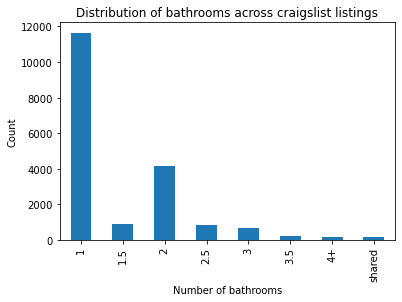

In [26]:
# Plot the distribution of bathrooms 
df['listing_bathrooms'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Number of bathrooms')
plt.ylabel('Count')
plt.title('Distribution of bathrooms across craigslist listings')

## 4. Clean listing_bedrooms column
Consolidate data into categories that belong together e.g. lump 6,7,8 bedroom places into 6+ bedrooms.

The bedroom category can also stay as a categorical feature

In [27]:
# Lump all bedrooms >= 6 into a single type '6+'
extra_bed = ['6', '7', '8']
df.loc[:,'listing_bedrooms'] = df['listing_bedrooms'].astype('str')
df['listing_bedrooms'][df['listing_bedrooms'].isin(extra_bed)] = '6+'
df['listing_bedrooms'].value_counts()

2     6298
1     6044
3     2971
0     1820
4     1155
5      257
6+      61
Name: listing_bedrooms, dtype: int64

Text(0.5, 1.0, 'Distribution of bedrooms across craigslist listings')

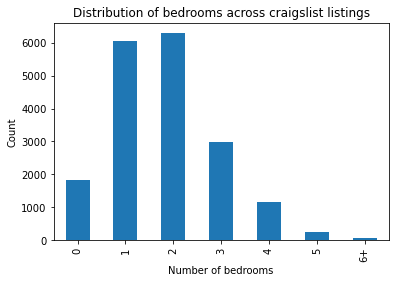

In [28]:
# Look at distributions of number of bedroom data
df['listing_bedrooms'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Number of bedrooms')
plt.ylabel('Count')
plt.title('Distribution of bedrooms across craigslist listings')

In [29]:
df.shape

(18606, 13)

## 5. Filter the listing_sqft column using a chosen min/max
This will eliminate obvious outliers and wrong inputs

In [30]:
df['listing_sqft'].describe()

count     12742.000000
mean       1090.650683
std        2032.156941
min           1.000000
25%         693.000000
50%         913.500000
75%        1260.000000
max      150000.000000
Name: listing_sqft, dtype: float64

In [31]:
df_rows_before_sqft = df.shape[0]
# If there is a sqft value, drop sqft values that are too small or too big (the 94103 is clearly a zip code)
sqft_min = 150
sqft_max = 4000

df_sqft_transformed = df.listing_sqft.replace('',np.nan)
print(f'The listing_sqft column is missing {df_sqft_transformed.isnull().sum()} rows of data')

df_transformed = df
df_transformed['listing_sqft'] = df_sqft_transformed
df_transformed = df_transformed.loc[(df_transformed.listing_sqft.isnull()) | ((df_transformed.listing_sqft > sqft_min) & (df_transformed.listing_sqft < sqft_max))]
df_rows_after_sqft = df_transformed.shape[0]
print(f'Dropped {df_rows_after_sqft-df_rows_before_sqft} rows that were outside the bounds of the min and max')

The listing_sqft column is missing 5864 rows of data
Dropped -103 rows that were outside the bounds of the min and max


In [32]:
df_transformed['listing_sqft'].describe()

count    12639.000000
mean      1050.283883
std        545.858756
min        155.000000
25%        697.000000
50%        915.000000
75%       1255.500000
max       3999.000000
Name: listing_sqft, dtype: float64

## 6. Extract listing_info keywords
Since these keywords are optional inputs in Craigslist.com, the string varies in length. 
Convert from a string into a list of values that will be converted to their own columns. 

In [33]:
# Convert listing_info from string of values to a list of values
df_transformed['listing_info_split'] = df_transformed['listing_info'].apply(lambda x: x.strip().split("  "))

In [34]:
for target_info, column in LISTING_INFO_TO_COLUMN.items():
    df_transformed[column] = df_transformed['listing_info_split'].apply(lambda x: get_listing_info_feature(x, target_info))

In [35]:
df_transformed.head()

,listing_title,listing_nh,listing_city,listing_date,listing_price,listing_bedrooms,listing_bathrooms,listing_sqft,listing_address,listing_info,...,rent_period_weekly,rent_period_monthly,housing_condo,housing_apt,housing_cottage,housing_duplex,housing_flat,housing_house,housing_inlaw,housing_townhouse
listing_id,,,,,,,,,,,,,,,,,,,,,
7520103440,Beautiful and Spacious NEW remodeled Silicon V...,fremont / union city / newark,Fremont,2022-08-11 09:51:58-07:00,3800,3,2,1495.0,Newport Dr,open house dates saturday 2022-08-13 sun...,...,0,0,0,0,0,0,0,0,0,0
7520292010,"Spacious, bright live/work loft with all utili...",oakland west,Oakland,2022-08-11 16:49:29-07:00,2450,1,1,925.0,1468 32nd St near louise,application fee details: $45 cats are OK - p...,...,0,1,0,0,0,0,0,0,1,0
7520905091,Highly desired Vista neighborhood with a charm...,vallejo / benicia,Vallejo,2022-08-13 09:04:22-07:00,2100,2,1,904.0,226 Edgemont Avenue near Edgemont Avenue,EV charging air conditioning cats are OK - ...,...,0,1,0,0,0,0,0,1,0,0
7520907681,lovely 2-bedroom 2 bath home with open floor p...,vallejo / benicia,Vallejo,2022-08-13 09:09:26-07:00,2200,2,2,1420.0,1509 Sacramento Street near Sacramento Street,EV charging air conditioning cats are OK - ...,...,0,1,0,0,0,0,0,1,0,0
7520608095,"$3,935 / 2br - 1266ft2 - NEW LOW RATE! Spaciou...",dublin / pleasanton / livermore,Pleasanton,2022-08-12 12:34:49-07:00,3935,2,2,NaN,1552 E Gate Way,air conditioning application fee details: $5...,...,0,1,0,1,0,0,0,0,0,0


## 7. Filter the listing_city column based on how often it occurs
There are some typos in this column because it is a user input.
There are also some cities listed with state and punctuation that should be removed

In [36]:
df_transformed['listing_city'].value_counts()

San Francisco                     6185
Oakland                           2181
Berkeley                           832
Alameda                            373
san francisco                      368
                                  ... 
Nevada City                          1
El sobrante                          1
Rebecca                              1
Oakland,CA                           1
San Francisco - Outer Richmond       1
Name: listing_city, Length: 566, dtype: int64

In [37]:
df_transformed['listing_city'] = df_transformed['listing_city'].apply(lambda x: x.title())
df_transformed['listing_city'] = df_transformed['listing_city'].apply(lambda x: clean_city(x))
df_transformed['listing_city'].value_counts()

# Get index of cities that occur less than 5 times (these are typos or errors)
x = df_transformed['listing_city'].value_counts()
city_to_drop = list((x[x < 5]).index)

# Drop city values that are lower than a value count of 2
df_transformed['listing_city'] = df_transformed['listing_city'].apply(lambda x: None if x in city_to_drop else x)

In [38]:
df_transformed['listing_city'].value_counts().head()

San Francisco    6898
Oakland          2410
Berkeley          913
Fremont           408
Alameda           402
Name: listing_city, dtype: int64

## 8. Check the metro, neighborhood and listing_city is consistent
Some listings are posted in the wrong metro, or have incorrect neighborhood tags. Drop these rows 

In [39]:
# If a listing has a neighborhood tag, cross reference it with the listing_city to make sure it is in the correct city, otherwise remove from df
df_transformed['is_consistent_metro'] = df_transformed.apply(lambda x: correct_metro(x['listing_nh'], x['listing_city']), axis=1)
df_correct_metro = df_transformed[df_transformed['is_consistent_metro'] == True]

print(f'After checking for consistent metro, dropped {df_correct_metro.shape[0] - df_transformed.shape[0]} rows')
print(f'Database now has {df_correct_metro.shape[0]} rows')

After checking for consistent metro, dropped -2260 rows
Database now has 16243 rows


In [40]:
# Check there are not too many duplicated addresses
df_dup = df_correct_metro["listing_address"].notnull().duplicated()
duplicate_addresses = df_correct_metro[df_dup].groupby('listing_address').listing_title.count().sort_values(ascending=False)
duplicate_addresses[duplicate_addresses > 3]
# The max number of times an address shows up is only 8, which seems reasonable since some are apartment buildings

listing_address
3900 Adeline Street                                        8
669 24th Street                                            8
1011 Ygnacio Valley Rd near Walnut Blvd & Homestead Av     7
1011 Ygnacio Valley Rd near Walnut Blvd & Homestead Ave    7
312 24th St                                                6
                                                          ..
3068 Kyne Street W                                         4
611 Bounty Drive                                           4
260 30th Street                                            4
780 Oak Gove Road near Treat Blvd                          4
3900 Adeline Street near 39th                              4
Name: listing_title, Length: 179, dtype: int64

## 9. Add Walk Score, Transit Score and Bike Score
Use the address to match the corresponding Walk score, Transit score and Bike score


In [41]:
# Add walkscore data if there is an address in the listing
with contextlib.closing(sqlite3.connect(DATABASE)) as conn:
    df_correct_metro['address_score'] = df_correct_metro[['listing_address', 'listing_city']].apply(lambda x: get_address_score(conn, *x), axis=1)

In [42]:
# Separate scores into their own columns
df_correct_metro['walk_score'] = df_correct_metro['address_score'].apply(lambda x: x[0] if x else np.nan)
df_correct_metro['transit_score'] = df_correct_metro['address_score'].apply(lambda x: x[1] if x else np.nan)
df_correct_metro['bike_score'] = df_correct_metro['address_score'].apply(lambda x: x[2] if x else np.nan)

# Remove address_score column
df_correct_metro = df_correct_metro.drop(['address_score'], axis=1)

In [43]:
no_listing_address = len(df_correct_metro['listing_address'].notnull())
missing_walkscore = df_correct_metro['walk_score'].isnull().sum()
missing_transitscore = df_correct_metro['transit_score'].isnull().sum()
missing_bikescore = df_correct_metro['bike_score'].isnull().sum()

print(f"Number of listing addresses: {no_listing_address}")
print(f"Number of missing walk scores: {missing_walkscore}, {missing_walkscore*100/no_listing_address:.1f}% of addresses")
print(f"Number of missing transit scores: {missing_transitscore}, {missing_transitscore*100/no_listing_address:.1f}% of addresses")
print(f"Number of missing bike scores: {missing_bikescore}, {missing_bikescore*100/no_listing_address:.1f}% of addresses")

Number of listing addresses: 16243
Number of missing walk scores: 477, 2.9% of addresses
Number of missing transit scores: 2834, 17.4% of addresses
Number of missing bike scores: 2072, 12.8% of addresses


## 10. Handle missing values

In [44]:
# Missing values in numeric columns
missing = pd.concat([df_correct_metro.isnull().sum(), 100 * df_correct_metro.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count',ascending=False)

,count,%
listing_sqft,5352,32.949578
transit_score,2834,17.447516
bike_score,2072,12.756264
walk_score,477,2.936650
listing_address,399,2.456443
rent_period_monthly,0,0.000000
parking_attached_garage,0,0.000000
parking_detached_garage,0,0.000000
parking_offstreet,0,0.000000
parking_street,0,0.000000


There are about 30% of listing_sqft data missing and 3% of addresses missing.
To handle the missing listing_sqft values: 
1. Try and extract listing_sqft from the title of the craigslist post
2. otherwise in the preprocessing stage, impute the square footage value with the median value for the given number of bedroom/bathroom combo

To handle the missing address values: the address is used to get the walk score, transit score and bike score.
1. In the preprocessing stage, impute the mean walk score, transit score and bike score for the listing neighborhood

## 11. Extract listing_title keywords

In [45]:
# Use Regex to extract sqft and address information from listing_title for nan values
missing_sqft = df_correct_metro[df_correct_metro.listing_sqft.isnull()][['listing_title','listing_sqft']]

title_sqft = missing_sqft['listing_title'].apply(lambda x: parse_listing_title_sqft(x))
title_sqft = title_sqft[title_sqft.notnull()]

# Join the data on index
df = df_correct_metro.merge(title_sqft, left_index=True, right_index=True, how='left')

# Replace nan values in listing_sqft with values from title_sqft
df.loc[:,'listing_sqft'] = df['listing_sqft'].fillna(df['listing_title_y'])

# Delete the extra columns that are not needed
df = df.drop(['listing_title_y','is_consistent_metro'],axis=1)

# Rename listing_title
df.rename(columns = {'listing_title_x':'listing_title'}, inplace = True)

In [46]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count',ascending=False)

,count,%
listing_sqft,5342,32.888013
transit_score,2834,17.447516
bike_score,2072,12.756264
walk_score,477,2.936650
listing_address,399,2.456443
rent_period_monthly,0,0.000000
parking_attached_garage,0,0.000000
parking_detached_garage,0,0.000000
parking_offstreet,0,0.000000
parking_street,0,0.000000


## 12. Convert dtypes of bedrooms and bathrooms columns

In [47]:
df['listing_bedrooms'].unique()

array(['3', '1', '2', '0', '4', '5', '6+'], dtype=object)

In [48]:
df['listing_bathrooms'].unique()

array(['2', '1', '2.5', '1.5', '4+', '3', '3.5', 'shared'], dtype=object)

In [49]:
# Convert the bedroom and bathroom features into numeric ones
df.loc[:,"no_bedrooms"] = pd.to_numeric(df["listing_bedrooms"].str.replace('+', ''))
df.loc[:,"no_bathrooms"] = pd.to_numeric(df["listing_bathrooms"].str.replace('+', '').str.replace('shared', '0.5'))

## 13. Extract listing_body into keywords
The listing_body contains the bulk of the text in a craigslist listing. 
There is a lot of information as text and provides a good summary of the rental unit, but most of the details in the body are already in the feature columns.

Use the dictionary LISTING_BODY_TO_COLUMN to parse the most important details: 
* Is the place rent controlled
* Are pets allowed 
* Has the place been remodelled
* Are there amenities that come with the rental unit e.g. pool, gym, spa
* If there are premium finishings e.g. marble
* If there are balconies, views

In [50]:
for target_word, column_name in LISTING_BODY_TO_COLUMN.items():
    df[column_name] = df['listing_body'].apply(lambda x: parse_listing_body(x, target_word))

# Check the listing is for the entire place and not a shared one (if it is, the listing is misclassified and the row should be removed)
# for target_word, column_name in LISTING_BODY_NUM.items():
#     df[column_name] = df['listing_body'].apply(lambda x: parse_listing_number(x, target_word))


In [51]:
# How many rows did the listing_body indicate were shared places looking for a roommate?
df.is_shared.value_counts()

0    13053
1     3190
Name: is_shared, dtype: int64

In [52]:
# Drop rows that are a shared listing and are looking for housemates
df = df[df.is_shared == 0]
df = df.drop(['is_shared'],axis=1)

In [53]:
# Drop rows that are single rooms for rent (square footage is small) but list multiple bedrooms for the property
# OR drop rows that have 2+ bedrooms but are listed for less than $1000. This criteria is Bay Area specific
# OR drop rows that are 1 bedroom, shared bathroom 
index_names = df[((df['listing_sqft'] < 400) & (df['no_bedrooms'] > 1)) | ((df['no_bedrooms'] > 1) & (df['listing_price'] < 1500)) | ((df['no_bedrooms'] == 1)) & (df['no_bathrooms'] == 0.5)].index
df.drop(index_names, inplace = True)

In [54]:
# Check if listing_body has a different number of bedrooms/bathrooms than what is in the listing. 
# Use the info from the listing_body if there is a conflict (manually typed text is more likely to be correct than the drop down menu)

# df['listing_bedrooms'] = np.where((df['listing_bedrooms'] != df['text_no_bedrooms']), df['listing_bedrooms'], df['text_no_bedrooms'])

# df['listing_bathrooms'] = np.where((df['listing_bathrooms'] != df['text_no_bathrooms']), df['listing_bathrooms'], df['text_no_bathrooms'])

In [55]:
# Drop columns text_no_bedrooms and text_no_bathrooms
# df.drop(['text_no_bedrooms','text_no_bathrooms'],axis=1, inplace=True)

## 14. Summarize the data visually

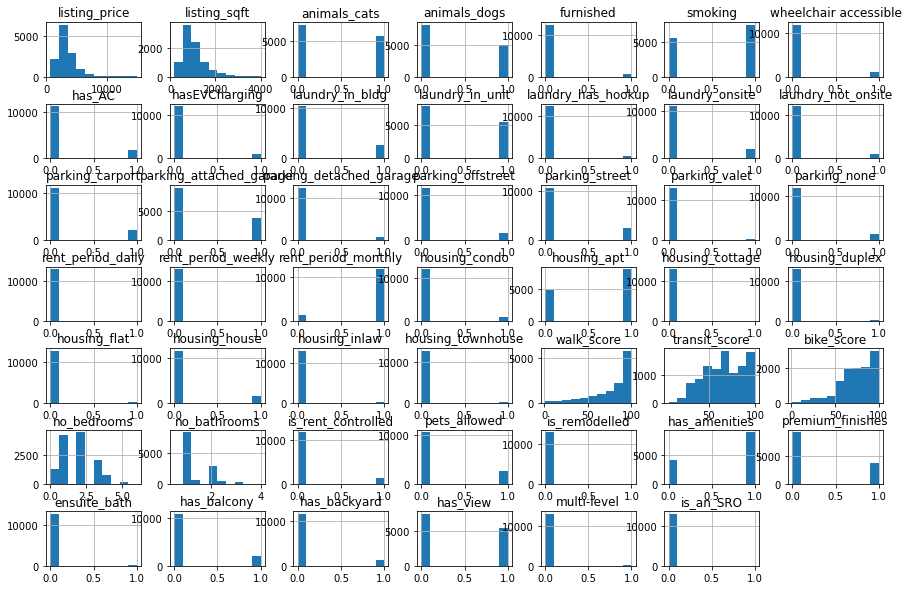

In [56]:
df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13020 entries, 7520103440 to 7532425139
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   listing_title            13020 non-null  object 
 1   listing_nh               13020 non-null  object 
 2   listing_city             13020 non-null  object 
 3   listing_date             13020 non-null  object 
 4   listing_price            13020 non-null  int64  
 5   listing_bedrooms         13020 non-null  object 
 6   listing_bathrooms        13020 non-null  object 
 7   listing_sqft             8918 non-null   float64
 8   listing_address          12695 non-null  object 
 9   listing_info             13020 non-null  object 
 10  listing_body             13020 non-null  object 
 11  listing_url              13020 non-null  object 
 12  listing_first_image      13020 non-null  object 
 13  listing_info_split       13020 non-null  object 
 14  animals_

In [58]:
df.to_csv(r'/Users/pandabear/springboard/CapstoneTwoProject/data/interim/listing_df_cleaned.csv', header=True)
print('Saved to csv file')

Saved to csv file


In [59]:
df.shape

(13020, 60)